### Урок 3. Классификация на практикеОдин из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.

Создайте модель линейной регрессии, которая бы оценивала лояльность пользователей к отклнта.

Пояснения к признакам набора данных:

• AGREEMENT_RK — уникальный идентификатор объекта в выборке;

• TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);

• AGE — возраст клиента;

• SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);

• SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);

• GENDER — пол клиента (1 — мужчина, 0 — женщина);

• CHILD_TOTAL — количество детей клиента;

• DEPENDANTS — количество иждивенцев клиента;

• PERSONAL_INCOME — личный доход клиента (в рублях);

• LOAN_NUM_TOTAL — количество ссуд клиента;

• LOAN_NUM_CLOSED — количество погашенных ссуд клиента.

In [202]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [124]:
# Загрузка данных
data = pd.read_csv("ClientsData.csv")
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                15223 non-null  int64  
 1   SOCSTATUS_WORK_FL  15223 non-null  int64  
 2   SOCSTATUS_PENS_FL  15223 non-null  int64  
 3   GENDER             15223 non-null  int64  
 4   CHILD_TOTAL        15223 non-null  int64  
 5   DEPENDANTS         15223 non-null  int64  
 6   PERSONAL_INCOME    15223 non-null  float64
 7   LOAN_NUM_TOTAL     15223 non-null  int64  
 8   LOAN_NUM_CLOSED    15223 non-null  int64  
 9   LOAN_DLQ_NUM       15223 non-null  int64  
 10  TARGET             15223 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.3 MB


In [126]:
data.duplicated().sum()

2819

In [127]:
#Дуюликаты есть, но мы не можем их удалить, так как нет гарантии, что это именно дубликаты, а не разные люди
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,15223.0,40.406096,11.601068,21.0,30.0,39.0,50.0,67.0
SOCSTATUS_WORK_FL,15223.0,0.909610,0.286748,0.0,1.0,1.0,1.0,1.0
SOCSTATUS_PENS_FL,15223.0,0.134468,0.341165,0.0,0.0,0.0,0.0,1.0
GENDER,15223.0,0.654536,0.475535,0.0,0.0,1.0,1.0,1.0
CHILD_TOTAL,15223.0,1.099389,0.995411,0.0,0.0,1.0,2.0,10.0
DEPENDANTS,15223.0,0.645208,0.812252,0.0,0.0,0.0,1.0,7.0
PERSONAL_INCOME,15223.0,13853.836323,9015.467617,24.0,8000.0,12000.0,17000.0,250000.0
LOAN_NUM_TOTAL,15223.0,1.387769,0.793566,1.0,1.0,1.0,2.0,11.0
LOAN_NUM_CLOSED,15223.0,0.751889,0.988499,0.0,0.0,0.0,1.0,11.0
LOAN_DLQ_NUM,15223.0,0.195362,0.685022,0.0,0.0,0.0,0.0,13.0


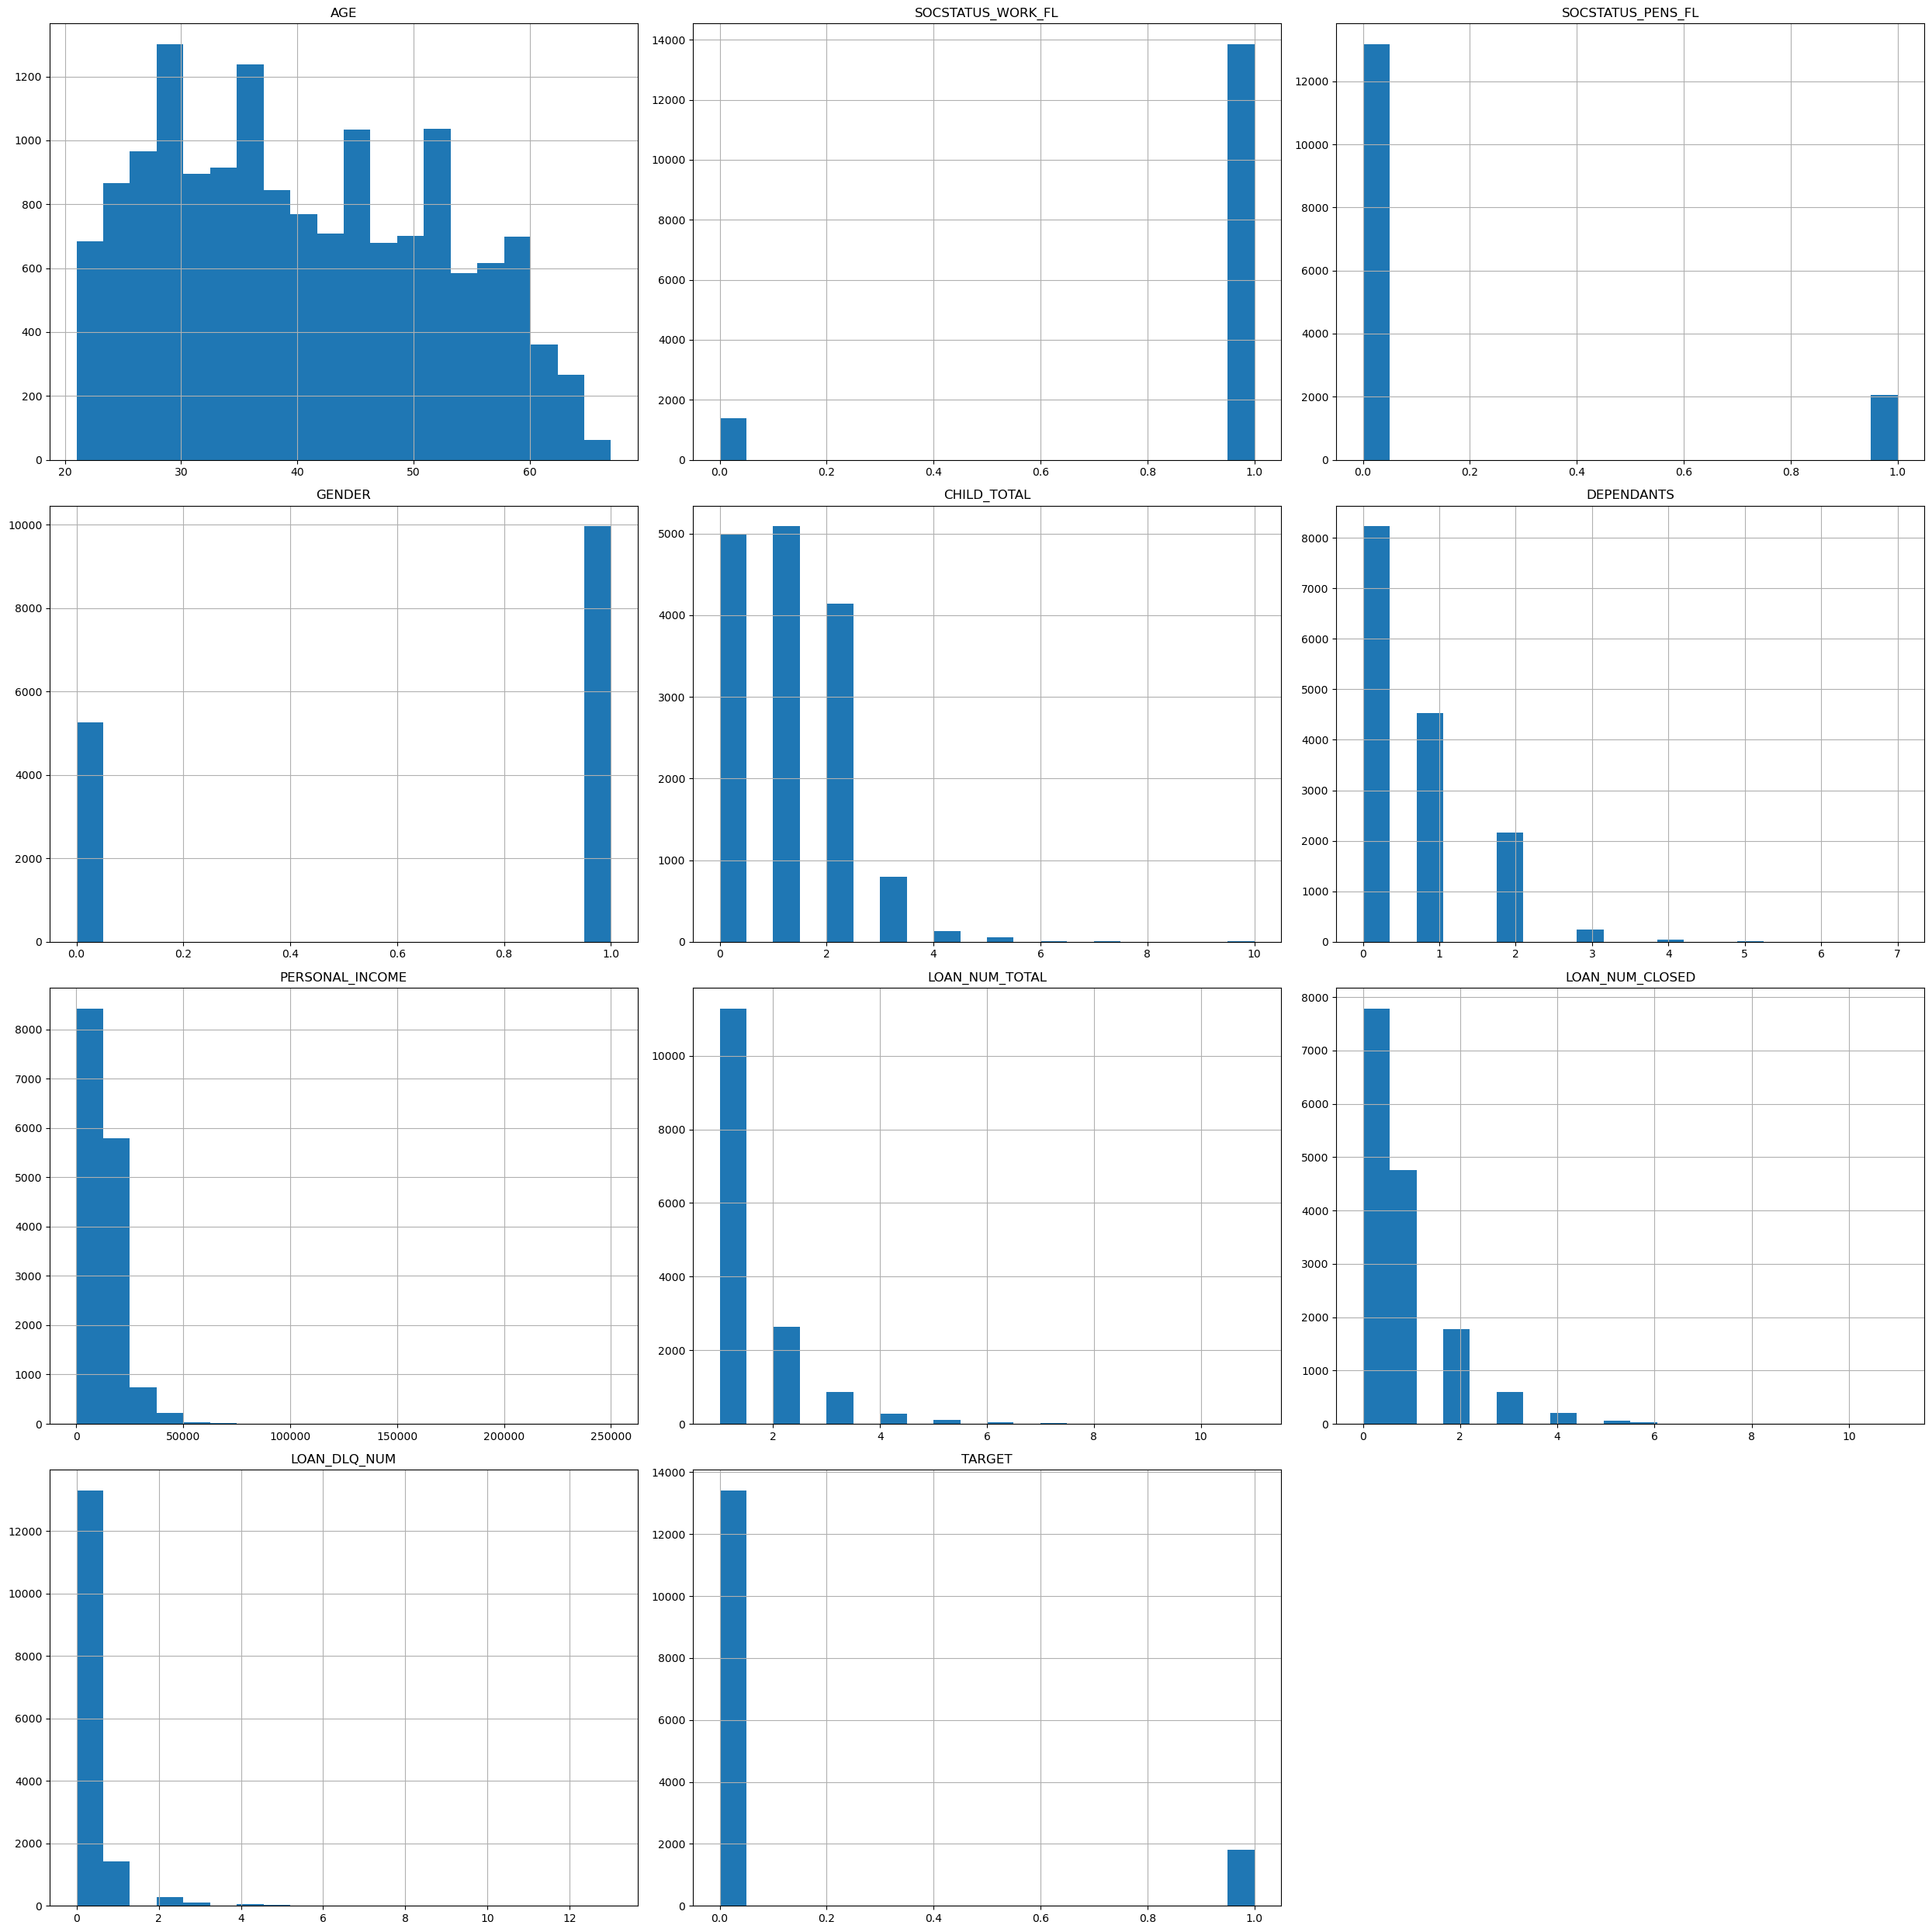

In [128]:
data.hist(figsize=(25, 25), bins=20)
plt.tight_layout()

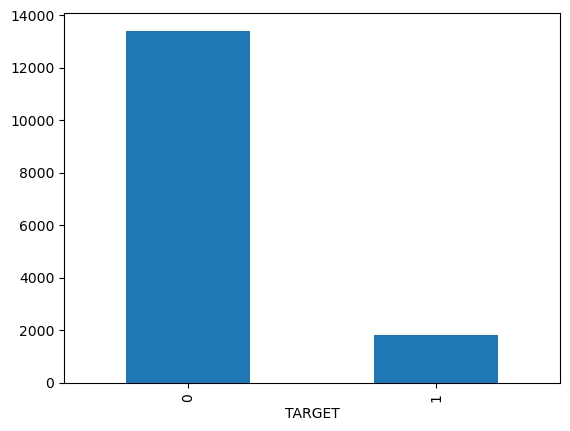

In [129]:
data.TARGET.value_counts().plot(kind='bar');

Можно отметить сильный дисбаланс классов. 

In [130]:
# Масштабирование  признаков
scaler = StandardScaler()
scaled_data= scaler.fit_transform(data.drop("TARGET", axis=1))

In [131]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(scaled_data, data["TARGET"], test_size=0.2, random_state=42)

In [135]:
#Обучаем модель линейной регрессии
model_lr= LinearRegression()
model_lr.fit(X_train, y_train)
y_lr_pred  = model_lr.predict(X_test)

In [137]:
#Посмотрим на результаты предсказаний модели
check_test = pd.DataFrame({
    "y_test": y_test,
    "y_lr_pred": y_lr_pred.flatten(),
})

check_test.head(10)

,y_test,y_lr_pred
6319,0,0.222122
4252,0,0.136051
2323,0,0.141629
6896,1,0.169138
3299,0,0.144194
11752,0,0.101440
8139,0,0.122614
4983,0,0.133231
15163,0,0.158171
14049,0,0.100875


In [180]:
#веса модели
model_lr.coef_

array([-0.02623255,  0.00483217, -0.00445227,  0.00185896,  0.00759911,
        0.001706  ,  0.02872034,  0.0238226 , -0.04165221,  0.01424094])

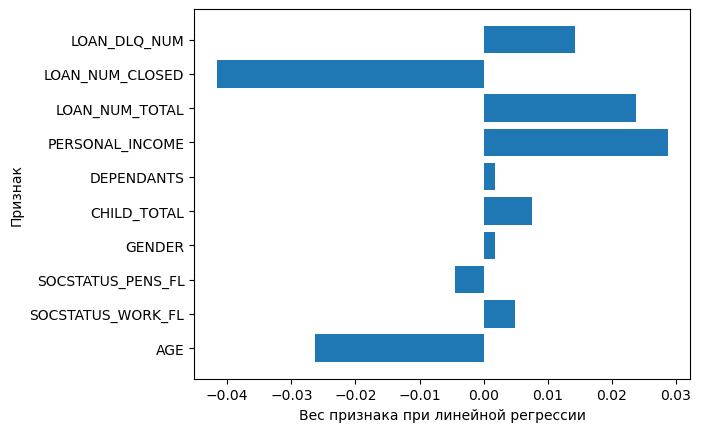

In [298]:
#Отобразим значимость признаков 
plt.barh(data.drop("TARGET", axis=1).columns, model_lr.coef_.flatten())

plt.xlabel("Вес признака при линейной регрессии")
plt.ylabel("Признак")

plt.show()

Text(0.5, 0, 'Значения, предсказанные линейной регрессией')

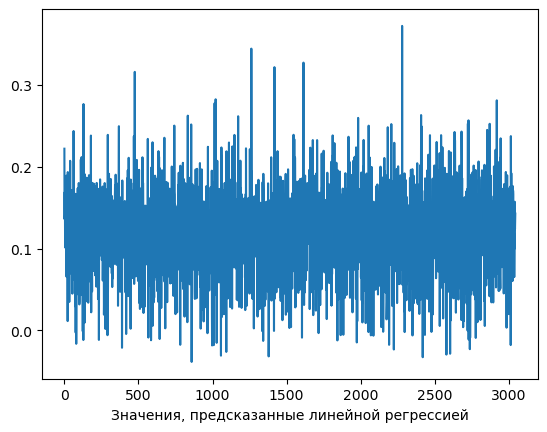

In [299]:
plt.plot(y_lr_pred)
plt.xlabel("Значения, предсказанные линейной регрессией")

Так как мы имеет несбалансированную выборку (объектов одного класса сильно больше, чем объектов другого), то для задачи классификации недостаточно использовать только метрику accuracy, которая равна доле правильных ответов классификатора к общему количеству объектов в выборке. Такая метрика очень плохо работает в случае несбалансированной выборки. Оценим нашу модеть так же с помощью Precision, Recall, F1-мера, AUC.

In [302]:
#Оценим, при какой границе между классами наша модель выдаст максимальную метрику f1.
thresholds = np.linspace(0, 0.2, 50)
recalls = {}
for threshold in thresholds:
    recalls[f1_score(y_test, (y_lr_pred > threshold).astype(int))] = threshold
lr_best_threshold = recalls[max(recalls.keys())]
print(f'Лучшая граница разделения классов для модели линейной регрессии {lr_best_threshold}')

Лучшая граница разделения классов для модели линейной регрессии 0.1346938775510204


In [303]:
# Оценим качество модели по всем метрикам с учетом лучшей границы разделения классов
print('Модель линейной регрессии:')
print("Accuracy:", accuracy_score(y_test, (y_lr_pred > lr_best_threshold).astype(int)))
print("Precision:", precision_score(y_test, (y_lr_pred > lr_best_threshold).astype(int)))
print("Recall:", recall_score(y_test, (y_lr_pred > lr_best_threshold).astype(int)))
print("F1-мера:", f1_score(y_test, (y_lr_pred > lr_best_threshold).astype(int)))
print("AUC:", roc_auc_score(y_test, y_lr_pred))

Модель линейной регрессии:
Accuracy: 0.6423645320197044
Precision: 0.1875
Recall: 0.5853658536585366
F1-мера: 0.2840236686390532
AUC: 0.6588014105103682


### L1 регулязация
Рассмотрим модель линейной регрессии с L1 регуляризацией. Посмотрим, как быстро затухают признаки.

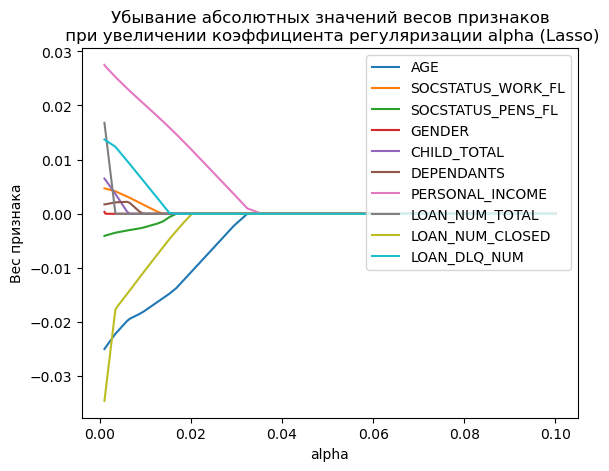

In [304]:
n = 50
important_features = data.drop("TARGET", axis=1).columns
important_features
coeffs = np.zeros((n, len(important_features)))
alpha_list = np.logspace(-3, -1, n)

for i, val in enumerate(alpha_list):
    lasso = Lasso(alpha=val)
    lasso.fit(pd.DataFrame(X_train, columns=important_features).loc[:, important_features], y_train)
    
    coeffs[i, :] = lasso.coef_.flatten()

for i in range(len(important_features)):
    plt.plot(alpha_list, coeffs[:, i])

plt.title('Убывание абсолютных значений весов признаков\n при увеличении коэффициента регуляризации alpha (Lasso)')

plt.xlabel('alpha')
plt.ylabel('Вес признака')

plt.legend(important_features, loc= 'upper right')

In [335]:
#Оценим, при какой alfa и какой границе между классами наша модель выдаст максимальную метрику f1.
thresholds = np.linspace(0, 0.2, 50)
alfa = np.linspace(0, 0.03, 50)
df_l1 = pd.DataFrame(columns = ['alpha', 'threshold', 'f1_score'])
df_l1
for a in alfa:
    model_lasso= Lasso(alpha=a)
    model_lasso.fit(X_train, y_train)
    y_lasso_pred = model_lasso.predict(X_test)
    for threshold in thresholds:
        df_l1.loc[len(df_l1.index)]=[a, threshold, f1_score(y_test, (y_lasso_pred > threshold).astype(int))]
df_l1
#        recalls[f1_score(y_test, (y_lasso_pred > threshold).astype(int))] = threshold
#lasso_best_threshold = recalls[max(recalls.keys())]
#print(f'Лучшая граница разделения классов для модели линейной регрессии c L1 регудяризацией {lasso_best_threshold}')

,alpha,threshold,f1_score
0,0.00,0.000000,0.219251
1,0.00,0.004082,0.219970
2,0.00,0.008163,0.220233
3,0.00,0.012245,0.221024
4,0.00,0.016327,0.221622
...,...,...,...
2495,0.03,0.183673,0.000000
2496,0.03,0.187755,0.000000
2497,0.03,0.191837,0.000000
2498,0.03,0.195918,0.000000


In [343]:
#Посмотрим параметры наибольшей f1
df_l1.iloc[df_l1[df_l1.f1_score== max(df_l1.f1_score)].index]

,alpha,threshold,f1_score
33,0.0,0.134694,0.284024


Из этих данных можно сделать вывод, что L1 регяляризация не улучшаем нашу модель линейной регрессии, она быстро обнуляет веса признаком и дает наилучшую метрику f1 при alpha=0, то есть на модели обычной линейной регрессии.

### L2 регуляризация

In [111]:
# Создание модели линейной регрессии с L2-регуляризацией (Ridge)
model_ridge = Ridge()

In [355]:
alpha = np.linspace(0.1, 10, 50)

In [347]:
# Подбор параметров модели с помощью GridSearchCV
param_grid = {"alpha": alpha}
grid_search = GridSearchCV(model3, param_grid, scoring="f1", cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.3122449 ,  1.51428571,  1.71632653,  1.91836735,
        2.12040816,  2.32244898,  2.5244898 ,  2.72653061,  2.92857143,
        3.13061224,  3.33265306,  3.53469388,  3.73673469,  3.93877551,
        4.14081633,  4.34285714,  4.54489796,  4.74693878,  4.94897959,
        5.15102041,  5.35306122,  5.55510204,  5.75714286,  5.95918367,
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ])},
             scoring='f1')

In [348]:
# Лучшая модель
best_model = grid_search.best_estimator_

In [349]:
y_ridge_pred = best_model.predict(X_test)

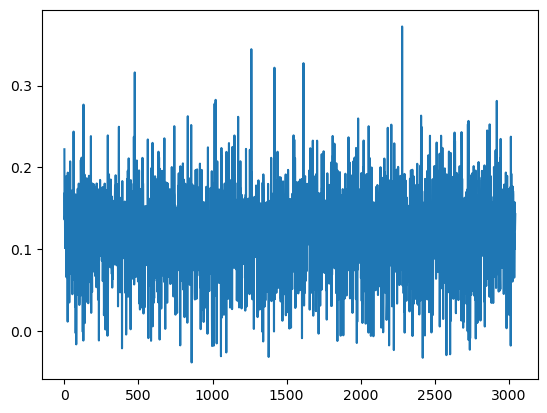

In [351]:
plt.plot(y_ridge_pred)

In [352]:
#Оценим, при какой границе между классами наша модель выдаст максимальную метрику f1.
thresholds = np.linspace(0, 0.2, 50)
recalls = {}
for threshold in thresholds:
    recalls[f1_score(y_test, (y_ridge_pred > threshold).astype(int))] = threshold
ridge_best_threshold = recalls[max(recalls.keys())]
print(f'Лучшая граница разделения классов для модели линейной регрессии c L2 {ridge_best_threshold}')

Лучшая граница разделения классов для модели линейной регрессии c L2 0.1346938775510204


In [354]:
# Оценка качества модели
print("Точность:", accuracy_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("Точность:", precision_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("Полнота:", recall_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("F1-мера:", f1_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("AUC:", roc_auc_score(y_test, y_ridge_pred))

Точность: 0.6423645320197044
Точность: 0.1875
Полнота: 0.5853658536585366
F1-мера: 0.2840236686390532
AUC: 0.6587973596477371


In [356]:
#Оценим, при какой границе между классами наша модель выдаст максимальную метрику accuracy.
thresholds = np.linspace(0, 0.2, 50)
recalls = {}
for threshold in thresholds:
    recalls[accuracy_score(y_test, (y_ridge_pred > threshold).astype(int))] = threshold
ridge_best_threshold = recalls[max(recalls.keys())]
print(f'Лучшая граница разделения классов для модели линейной регрессии c L2 {ridge_best_threshold}')
# Оценка качества модели
print("Точность:", accuracy_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("Точность:", precision_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("Полнота:", recall_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("F1-мера:", f1_score(y_test, (y_ridge_pred > ridge_best_threshold).astype(int)))
print("AUC:", roc_auc_score(y_test, y_ridge_pred))

Лучшая граница разделения классов для модели линейной регрессии c L2 0.2
Точность: 0.8597701149425288
Точность: 0.2542372881355932
Полнота: 0.08130081300813008
F1-мера: 0.12320328542094455
AUC: 0.6587973596477371


L2 регуляризация так же не улучшила модели. Так как классы не сбалансированы, то я ориентировалась на оценку качества модели исходя из метрики f1. Наимлучшая метрика f1 равна 0,28 при точности accuracy 0,64. Если оптимизаровать задачу не по метрике f1, а по accuracy, то максимальная достигаемая точность составит 0,86 при f1 0,12.  Модель получилась со средними  обощающими свойствами и регуляризация не помогла их улучшить. Возможно, другие модели дадут более качественные результаты.